In [12]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input
import matplotlib.pyplot as plt

# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# !python -m atari_py.import_roms /content/drive/MyDrive/optimization_colabs/Roms/

In [4]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[35:195,:,:].copy() # crop the top of the image...score image doesn't matter for how to play
    I = I[::2,::2,0].copy()
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I.copy())

In [5]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(32,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(64,(4,4),strides=2,activation='relu')(mid)
    mid = Conv2D(64,(3,3),strides=1,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(512,activation='relu')(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(1,activation='linear',name='out0')(mid)
    out1 = Dense(1,activation='linear',name='out1')(mid)
    out2 = Dense(1,activation='linear',name='out2')(mid)
    out3 = Dense(1,activation='linear',name='out3')(mid)
    model = Model(imp,[out0,out1,out2, out3]) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=25e-6),loss=tf.keras.losses.Huber())
    
    return model

In [6]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [0,1, 2,3]
# mod = create_model(80,80,frames_to_net)
# mod.call = tf.function(mod.call,experimental_relax_shapes=True)

# mod.summary()

In [7]:
mod = tf.keras.models.load_model('saved_model/dql-demon-attack')
# Check its architecture
mod.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 32)   8224        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 6, 6, 64)     36928       ['conv2d_1[0][0]']               
                                                                                              

In [9]:
def play1game(model,ep):
    env0 = gym.make("DemonAttack-v0")
    pix = env0.reset()
    pix = prepro(pix)
    frames_this_game = 0
    feed = np.zeros((1,80,80,frames_to_net))
    feed[0,:,:,0] = pix.copy() # 0 is the most recent frame t; 1 the previous one t+1 and so one
    
    frame_array = []
    action_array = []
    reward_array = []
    
    score = 0
    done = False
    while not done:
        if np.random.random() < ep:
            action = np.random.choice(3)
        else:
            vf = mod(feed,training=False)
            vf = [vf[0][0,0].numpy(),vf[1][0,0].numpy(),vf[2][0,0].numpy()]
            action = np.argmax(vf)
        action0 = possible_actions[action]
        pix_new, reward, done, info = env0.step(action0)
        frame_array.append(pix)
        action_array.append(action)
        reward_array.append(reward)
        pix = prepro(pix_new)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward
    return frame_array, action_array, reward_array, score

In [13]:
# ngames = 1000
ngames = 100
epsvec = np.linspace(1,0.05,int(ngames/10))
# ngames = 10
delt = 0.99
nbatch = 64
output = {'game':[-1]*ngames, 'score':[-100]*ngames, 'time':[-1]*ngames}

In [26]:
for game in range(ngames):
    
    if game < int(ngames/10):
        eps = epsvec[game]
    else:
        eps = epsvec[-1]
    
    start = time.time()
    frames, actions, rewards, score = play1game(mod,eps)

    nframes = len(frames)
    current_frames = np.zeros((nframes,80,80,frames_to_net))
    future_frames = np.zeros((nframes,80,80,frames_to_net))
  
    # creating frame - current t (for prediction) and t+1 (for truth)
    for grab in range(nframes):
        for f in range(frames_to_net):
            if grab-f > 0:
                current_frames[grab,:,:,f] = frames[grab-f].copy()
            if (grab-f+1 > 0) & (grab-f+1 < (nframes-1)):
                future_frames[grab,:,:,f] = frames[grab-f+1].copy()
    target_vf = mod.predict(future_frames)

    # vectors of truth
    y0 = np.zeros((nframes,1))
    y1 = np.zeros((nframes,1))
    y2 = np.zeros((nframes,1))
    y3 = np.zeros((nframes,1))
    
    # weight for training neural network based on the "truth"
    weight0 = np.zeros(nframes)
    weight1 = np.zeros(nframes)
    weight2 = np.zeros(nframes)
    weight3 = np.zeros(nframes)
  

    for grab in range(nframes):
        rhs = rewards[grab]
        # terminal condition will be when we win a game
        # 
        if rhs == 0:
            rhs = delt*np.max([target_vf[0][grab],target_vf[1][grab],target_vf[2][grab],target_vf[3][grab]])
        if actions[grab] == 0:
            y0[grab,0] = rhs
            weight0[grab] = 1
        elif actions[grab] == 1:
            y1[grab,0] = rhs
            weight1[grab] = 1
        elif actions[grab] == 2:
            y2[grab,0] = rhs
            weight2[grab] = 1
        else:
            y3[grab,0] = rhs
            weight3[grab] = 1
  
    mod.fit(current_frames,[y0,y1,y2,y3],epochs=1,batch_size=nbatch,verbose=0,
            sample_weight={'out0':weight0,'out1':weight1,'out2':weight2,'out3':weight3},use_multiprocessing=True)
    stop = time.time()
    
    output['game'][game] = game
    output['score'][game] = score
    output['time'][game] = time
    
    if game % 10 == 0:
        print('Game number ', game, [score, eps, stop-start], nframes)

Game number  0 [70.0, 1.0, 21.859464645385742] 10000
Game number  10 [385.0, 0.05, 35.75107741355896] 3952
Game number  20 [190.0, 0.05, 14.506853103637695] 1666


KeyboardInterrupt: 

In [32]:
# mod.save('saved_model/dql-demon-attack')

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO:tensorflow:Assets written to: saved_model/dql-demon-attack\assets


C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([77., 13.,  5.,  2.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-100.,   32.,  164.,  296.,  428.,  560.,  692.,  824.,  956.,
        1088., 1220.]),
 <BarContainer object of 10 artists>)

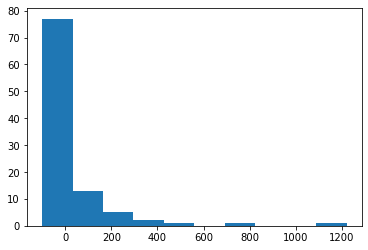

In [29]:
import matplotlib.pyplot as plt
plt.hist(output['score'])

In [10]:
nsims = 200
score_list = []

for sim in range(nsims):
    _, _, _, score = play1game(mod,0.05)
    if sim % 10 == 0:
        print('Simulation done ', sim, ' mean score is ', np.mean(score_list))
    score_list.append(score)


C:\Users\gupta\anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment DemonAttack-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/DemonAttack-v5`.
  logger.warn(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\gym\utils\seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(
C:\Users\gupta\anaconda3\lib\site-packages\numpy\core\fromnum

Simulation done  0  mean score is  nan
Simulation done  10  mean score is  94.0
Simulation done  20  mean score is  115.25
Simulation done  30  mean score is  136.66666666666666
Simulation done  40  mean score is  149.625
Simulation done  50  mean score is  161.2
Simulation done  60  mean score is  158.91666666666666
Simulation done  70  mean score is  154.71428571428572
Simulation done  80  mean score is  154.4375
Simulation done  90  mean score is  155.94444444444446
Simulation done  100  mean score is  161.3
Simulation done  110  mean score is  159.0909090909091
Simulation done  120  mean score is  160.875
Simulation done  130  mean score is  158.07692307692307
Simulation done  140  mean score is  157.32142857142858
Simulation done  150  mean score is  157.36666666666667
Simulation done  160  mean score is  158.5625
Simulation done  170  mean score is  156.41176470588235
Simulation done  180  mean score is  158.22222222222223
Simulation done  190  mean score is  158.57894736842104


NameError: name 'plt' is not defined

In [11]:
np.mean(score_list)

161.7

C:\Users\gupta\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([65., 79.,  3., 36.,  5.,  9.,  1.,  1.,  0.,  1.]),
 array([ 30.,  93., 156., 219., 282., 345., 408., 471., 534., 597., 660.]),
 <BarContainer object of 10 artists>)

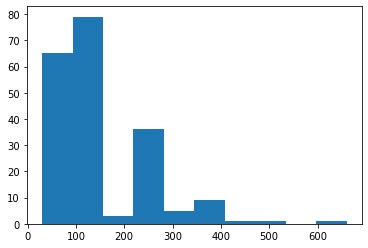

In [13]:
plt.hist(score_list) 